In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp ml.optimization.bfgs
from nbdev.showdoc import show_doc

See details in wiki https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm.

Also borrow from https://github.com/trsav/bfgs/blob/master/BFGS.py with refactorings:
1. refactoring plot code out
2. create a relative generic gradient function
3. remove many necessary parethesis
4. test against himmelblau

In [3]:
#export
from ml.optimization.grad import naive_grad


def line_search(f, grad_f, x0, p, nabla, c1=1e-4, c2=0.9):
    '''
    BACKTRACK LINE SEARCH WITH WOLFE CONDITIONS
    '''
    a = 1
    fx = f(x0)
    init_grad = grad_f(x0)
    
    x = x0 + a * p 
    nabla_new = grad_f(x)
    while f(x) >= fx + (c1*a*nabla.T@p) or nabla_new.T@p <= c2*nabla.T@p : 
        a *= 0.5
        x = x0 + a * p 
        nabla_new = grad_f(x)
    return a


def bfgs(f,x0,max_it,store=False):
    '''
    DESCRIPTION
    BFGS Quasi-Newton Method, implemented as described in Nocedal:
    Numerical Optimisation.
    INPUTS:
    f:      function to be optimised 
    x0:     intial guess
    max_it: maximum iterations 
    plot:   if the problem is 2 dimensional, returns 
            a trajectory plot of the optimisation scheme.
    OUTPUTS: 
    x:      the optimal solution of the function f 
    '''
    d = len(x0) # dimension of problem
    grad_f = naive_grad(f)
    nabla = grad_f(x0) # initial gradient 
    H = np.eye(d) # initial hessian
    x = x0[:]
    it = 2 
    if store == True: 
        if d == 2: 
            x_store =  np.zeros((1,2)) # storing x values 
            x_store[0,:] = x 
        else: 
            print('Too many dimensions to produce trajectory plot!')
            store = False

    while np.linalg.norm(nabla) > 1e-5: # while gradient is positive
        if it > max_it: 
            print('Maximum iterations reached!')
            break
        it += 1
        p = -H@nabla # search direction (Newton Method)
        a = line_search(f,grad_f, x, p, nabla) # line search 
        s = a * p 
        x_new = x + a * p 
        nabla_new = grad_f(x_new)
        y = nabla_new - nabla 
        y = np.reshape(y,(d,1))
        s = np.reshape(s,(d,1))
        
        r = 1/(y.T@s)
        li = np.eye(d)-r*(s@y.T)
        ri = np.eye(d)-r*(y@s.T)
        hess_inter = li@H@ri
        
        H = hess_inter + r*(s@s.T) # BFGS Update
        nabla = nabla_new[:]
        x = x_new[:]
        if store == True:
            x_store = np.append(x_store,[x],axis=0) # storing x
        
    return x, x_store


In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from ml.optimization.himmelblau import himmelblau

def f(x):
    return himmelblau(*x)

x_opt, x_store = bfgs(f, [-1.2, 1.0], 100, store=True)
    

In [5]:
x_store[:10]

array([[-1.2       ,  1.        ],
       [-2.868     ,  3.87      ],
       [-3.36615349,  3.69800826],
       [-2.5594052 ,  2.47965424],
       [-2.75948761,  2.95004783],
       [-2.83268273,  3.19701498],
       [-2.80662485,  3.12517748],
       [-2.80613424,  3.13085932],
       [-2.8053771 ,  3.13133625],
       [-2.80512898,  3.13132615]])

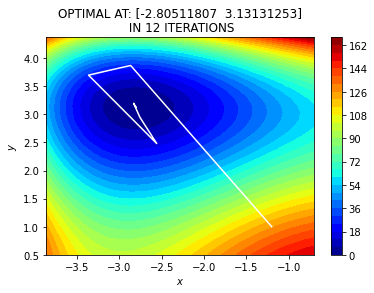

In [6]:
x1 = np.linspace(min(x_store[:,0]-0.5),max(x_store[:,0]+0.5),30)
x2 = np.linspace(min(x_store[:,1]-0.5),max(x_store[:,1]+0.5),30)

X1,X2 = np.meshgrid(x1,x2)
Z = f([X1,X2])
plt.figure()
plt.title('OPTIMAL AT: '+str(x_store[-1,:])+'\n IN '+str(len(x_store))+' ITERATIONS')
plt.contourf(X1,X2,Z,30,cmap='jet')
plt.colorbar()
plt.plot(x_store[:,0],x_store[:,1],c='w')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.show()